# Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones

Autores: Matías Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

##Enconding 

###OneHotEncoder

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

In [82]:
URL_MELB_HOUSING_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_housing_filtered_df.csv"
URL_MELB_SUBURB_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_suburb_filtered_df.csv"

melb_housing_df = pd.read_csv(URL_MELB_HOUSING_FILTERED)
melb_suburb_df = pd.read_csv(URL_MELB_SUBURB_FILTERED)

In [83]:
melb_combim = melb_housing_df.join(melb_suburb_df, on="suburb_id")
melb_combim[:5]

,housing_price,housing_room_segment,housing_bathroom_segment,housing_land_size,housing_building_area,housing_type,housing_year_built,suburb_id,suburb_name,suburb_region_segment,suburb_council_area,suburb_rental_dailyprice
0,1480000.0,"(1, 2]","(0, 1]",202.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
1,1035000.0,"(1, 2]","(0, 1]",156.0,79.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
2,1465000.0,"(2, 3]","(1, 2]",134.0,150.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
3,850000.0,"(2, 3]","(1, 2]",94.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
4,1600000.0,"(3, 4]","(0, 1]",120.0,142.0,h,2014.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512


In [84]:
categorical_cols = ["housing_room_segment", "housing_bathroom_segment", "housing_type", "suburb_name","suburb_region_segment", "suburb_council_area"]
numerical_cols = ["housing_price","housing_land_size","suburb_rental_dailyprice"]

In [72]:
print("housing_room_segment", melb_combim.housing_room_segment.nunique())
print("housing_bathroom_segment", melb_combim.housing_bathroom_segment.nunique())
print("housing_type", melb_combim.housing_type.nunique())
print("suburb_region_segment", melb_combim.suburb_region_segment.nunique())
print("suburb_council_area", melb_combim.suburb_council_area.nunique())
print("suburb_name", melb_combim.suburb_name.nunique())

housing_room_segment 5
housing_bathroom_segment 3
housing_type 3
suburb_region_segment 6
suburb_council_area 60
suburb_name 314


In [85]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
encoder.fit(melb_combim[categorical_cols])
# We can inspect the categories found by the encoder
encoder.categories_

[array(['(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]', '(4, 10]'], dtype=object),
 array(['(0, 1]', '(1, 2]', '(2, 8]'], dtype=object),
 array(['h', 't', 'u'], dtype=object),
 array(['Abbotsford', 'Aberfeldie', 'Airport West', 'Albanvale',
        'Albert Park', 'Albion', 'Alphington', 'Altona', 'Altona Meadows',
        'Altona North', 'Ardeer', 'Armadale', 'Ascot Vale', 'Ashburton',
        'Ashwood', 'Aspendale', 'Aspendale Gardens', 'Attwood',
        'Avondale Heights', 'Bacchus Marsh', 'Balaclava', 'Balwyn',
        'Balwyn North', 'Bayswater', 'Bayswater North', 'Beaconsfield',
        'Beaconsfield Upper', 'Beaumaris', 'Bellfield', 'Bentleigh',
        'Bentleigh East', 'Berwick', 'Black Rock', 'Blackburn',
        'Blackburn North', 'Blackburn South', 'Bonbeach', 'Boronia',
        'Box Hill', 'Braybrook', 'Briar Hill', 'Brighton', 'Brighton East',
        'Broadmeadows', 'Brookfield', 'Brooklyn', 'Brunswick',
        'Brunswick East', 'Brunswick West', 'Bulleen', 'Bullengarook',
   

In [86]:
encoded_types = encoder.transform(melb_combim[categorical_cols])
encoded_types[:10]

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [87]:
melb_numeric = melb_combim[numerical_cols].values
melb_numeric[:10]

array([[1.48000000e+06, 2.02000000e+02, 1.17719512e+02],
       [1.03500000e+06, 1.56000000e+02, 1.17719512e+02],
       [1.46500000e+06, 1.34000000e+02, 1.17719512e+02],
       [8.50000000e+05, 9.40000000e+01, 1.17719512e+02],
       [1.60000000e+06, 1.20000000e+02, 1.17719512e+02],
       [9.41000000e+05, 1.81000000e+02, 1.17719512e+02],
       [1.87600000e+06, 2.45000000e+02, 1.17719512e+02],
       [1.63600000e+06, 2.56000000e+02, 1.17719512e+02],
       [3.00000000e+05, 0.00000000e+00, 1.17719512e+02],
       [1.09700000e+06, 2.20000000e+02, 1.17719512e+02]])

In [88]:
matriz = np.hstack((encoded_types, melb_numeric))
matriz [:5]

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.48000000e+06, 2.02000000e+02, 1.17719512e+02],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.03500000e+06, 1.56000000e+02, 1.17719512e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.46500000e+06, 1.34000000e+02, 1.17719512e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        8.50000000e+05, 9.40000000e+01, 1.17719512e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60000000e+06, 1.20000000e+02, 1.17719512e+02]])

In [ ]:
matriz.shape

(13207, 394)

###DictVectorizer

In [89]:
feature_cols = ["housing_room_segment", "housing_bathroom_segment", "housing_type", "suburb_name","suburb_region_segment", "suburb_council_area",
"housing_price","housing_land_size","suburb_rental_dailyprice"]
feature_dict = list(melb_combim[feature_cols].T.to_dict().values())
feature_dict[:2]

[{'housing_bathroom_segment': '(0, 1]',
  'housing_land_size': 202.0,
  'housing_price': 1480000.0,
  'housing_room_segment': '(1, 2]',
  'housing_type': 'h',
  'suburb_council_area': "['Yarra']",
  'suburb_name': 'Abbotsford',
  'suburb_region_segment': 'Northern Metropolitan',
  'suburb_rental_dailyprice': 117.71951219512195},
 {'housing_bathroom_segment': '(0, 1]',
  'housing_land_size': 156.0,
  'housing_price': 1035000.0,
  'housing_room_segment': '(1, 2]',
  'housing_type': 'h',
  'suburb_council_area': "['Yarra']",
  'suburb_name': 'Abbotsford',
  'suburb_region_segment': 'Northern Metropolitan',
  'suburb_rental_dailyprice': 117.71951219512195}]

In [90]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
feature_matrix = vec.fit_transform(feature_dict)

In [ ]:
feature_matrix

<13207x394 sparse matrix of type '<class 'numpy.float64'>'
	with 118863 stored elements in Compressed Sparse Row format>

In [ ]:
vec.get_feature_names()

['housing_bathroom_segment=(0, 1]',
 'housing_bathroom_segment=(1, 2]',
 'housing_bathroom_segment=(2, 8]',
 'housing_land_size',
 'housing_price',
 'housing_room_segment=(0, 1]',
 'housing_room_segment=(1, 2]',
 'housing_room_segment=(2, 3]',
 'housing_room_segment=(3, 4]',
 'housing_room_segment=(4, 10]',
 'housing_type=h',
 'housing_type=t',
 'housing_type=u',
 "suburb_council_area=['Banyule', 'Nillumbik']",
 "suburb_council_area=['Banyule', 'Whittlesea', 'Darebin']",
 "suburb_council_area=['Banyule']",
 "suburb_council_area=['Bayside', 'Glen Eira']",
 "suburb_council_area=['Bayside', 'Kingston']",
 "suburb_council_area=['Bayside', 'Unavailable']",
 "suburb_council_area=['Bayside']",
 "suburb_council_area=['Boroondara', 'Stonnington']",
 "suburb_council_area=['Boroondara', 'Whitehorse']",
 "suburb_council_area=['Boroondara']",
 "suburb_council_area=['Brimbank']",
 "suburb_council_area=['Cardinia']",
 "suburb_council_area=['Casey']",
 "suburb_council_area=['Darebin', 'Banyule']",
 "s

# Imputación por KNN

In [91]:
at_least_onena= melb_combim['housing_year_built'].isna() | melb_combim['housing_building_area'].isna()
missing_values_indices= melb_combim[at_least_onena].index
melb_combim[at_least_onena]

,housing_price,housing_room_segment,housing_bathroom_segment,housing_land_size,housing_building_area,housing_type,housing_year_built,suburb_id,suburb_name,suburb_region_segment,suburb_council_area,suburb_rental_dailyprice
0,1480000.0,"(1, 2]","(0, 1]",202.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
3,850000.0,"(2, 3]","(1, 2]",94.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
5,941000.0,"(1, 2]","(0, 1]",181.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
8,300000.0,"(0, 1]","(0, 1]",0.0,NaN,u,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
10,700000.0,"(1, 2]","(1, 2]",0.0,NaN,u,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
...,...,...,...,...,...,...,...,...,...,...,...,...
13196,1323000.0,"(3, 4]","(1, 2]",551.0,NaN,h,NaN,216,Wantirna South,Eastern Metropolitan,['Knox'],95.238095
13197,970000.0,"(2, 3]","(1, 2]",674.0,NaN,h,NaN,216,Wantirna South,Eastern Metropolitan,['Knox'],95.238095
13201,582000.0,"(2, 3]","(1, 2]",256.0,NaN,h,NaN,218,Westmeadows,Northern Metropolitan,['Hume'],123.084156
13202,1245000.0,"(3, 4]","(1, 2]",652.0,NaN,h,1981.0,248,Wheelers Hill,South-Eastern Metropolitan,['Monash'],109.742268


In [92]:
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=2, weights="uniform"))

melb_combim.loc[:,['housing_year_built_imputer', 'housing_building_area_imputer']] = mice_imputer.fit_transform(
    melb_combim[['housing_year_built', 'housing_building_area']])



/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


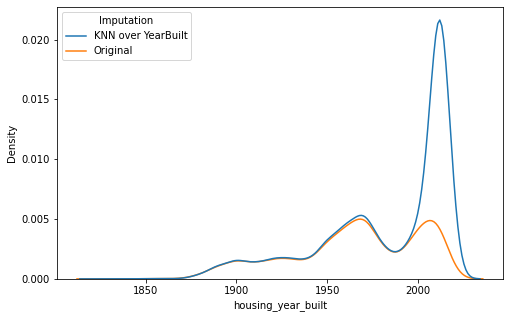

In [104]:
mice_year_built_knn = melb_combim["housing_year_built_imputer"].to_frame().rename(columns={"housing_year_built_imputer":"housing_year_built"})
mice_year_built_knn['Imputation'] = 'KNN over YearBuilt'
melb_year_built_orig = melb_combim["housing_year_built"].dropna().to_frame()
melb_year_built_orig['Imputation'] = 'Original'
data = pd.concat([mice_year_built_knn, melb_year_built_orig])
fig = plt.figure(figsize=(8, 5))
g = seaborn.kdeplot(data=data, x='housing_year_built', hue='Imputation')

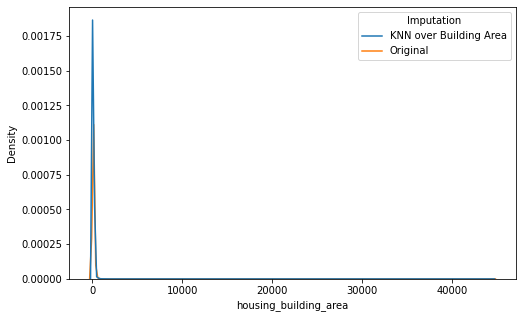

In [106]:
mice_build_area_knn = melb_combim["housing_building_area_imputer"].to_frame().rename(columns={"housing_building_area_imputer":"housing_building_area"})
mice_build_area_knn['Imputation'] = 'KNN over Building Area'
melb_build_area_orig = melb_combim["housing_building_area"].dropna().to_frame()
melb_build_area_orig['Imputation'] = 'Original'
data = pd.concat([mice_build_area_knn, melb_build_area_orig])
fig = plt.figure(figsize=(8, 5))
g = seaborn.kdeplot(data=data, x="housing_building_area", hue='Imputation')

In [101]:
print(melb_year_built_orig)

       housing_year_built Imputation
1                  1900.0   Original
2                  1900.0   Original
4                  2014.0   Original
6                  1910.0   Original
7                  1890.0   Original
...                   ...        ...
13202              1981.0   Original
13203              1995.0   Original
13204              1997.0   Original
13205              1920.0   Original
13206              1920.0   Original

[7966 rows x 2 columns]
